In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans

sns.set_theme()

In [2]:
df: pl.DataFrame = pl.read_parquet("data/processed/amazon-2023.parquet")

In [3]:
products: pl.DataFrame = df.group_by("parent_asin").agg([
    pl.len().alias("total_reviews"),
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("brand").first().fill_null("Unknown").str.to_lowercase().alias("brand_id"),
    pl.col("main_category").first().fill_null("Unknown").str.to_lowercase().alias("category_id"),
])

In [4]:
e: LabelEncoder = LabelEncoder()

products = products.with_columns(
    pl.Series(
        "brand_id",
        e.fit_transform(products["brand_id"]),
    ),
    pl.Series(
        "category_id",
        e.fit_transform(products["category_id"]),
    ),
)

In [5]:
X: pl.DataFrame = products.drop("parent_asin")

In [6]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

cluster_labels

array([3, 3, 1, ..., 0, 1, 1])

In [7]:
products: pl.DataFrame = products.with_columns(pl.Series("cluster", cluster_labels))

In [8]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

C:\Users\Felic\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


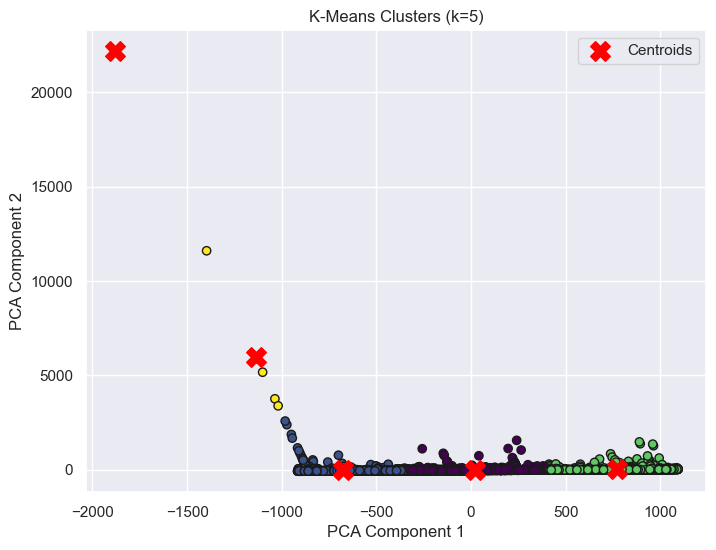

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_2D[:, 0], X_2D[:, 1], c=cluster_labels, cmap="viridis", marker="o", edgecolor="k"
)
plt.title(f"K-Means Clusters (k=5)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

centroids = kmeans.cluster_centers_
centroids_2D = pca.transform(centroids)
plt.scatter(
    centroids_2D[:, 0],
    centroids_2D[:, 1],
    c="red",
    marker="X",
    s=200,
    label="Centroids",
)

plt.legend()
plt.show()